# Notebook for preprocessing the LOFAR catalogues before XID+

it outputs a modified LOFAR radio data table with two new columns. the first column is XID+_rerun and is a boolean array stating whether a source should ahve XID+ rerun or not. The second is a string column that says what where the fir for that source comes from.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table,Column,join
import time

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

import fitIR
import fitIR.models as models
import fitIR.analyse as analyse

import pickle

import h5py

In [2]:
lamz = np.array([250., 350., 500., 880., 1110.]) # um
fluxes = np.array([12., 32.4, 47.3, 33., 21.3]) # mJy
errors = np.array([2.3, 2.3, 2.8, 2.4, 1.1])

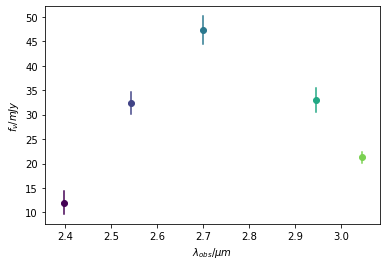

In [3]:
obs = fitIR.observations(lamz, fluxes, errors, cosmo)

analyse.plot_obs(obs)

# ---- initialise source

source = fitIR.source(obs, mod = 'greybody') 

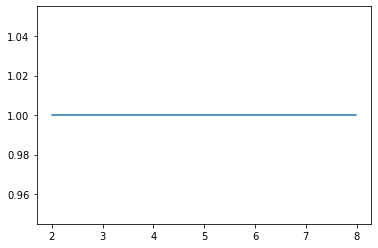

In [4]:
#create custom pdf for the redshift distribution
x = np.arange(2,8,0.01)
y = 0.1*x**3 - 0.2*x**2 - x + 8
y = np.zeros(len(x))+1

plt.plot(x,y)
plt.show()

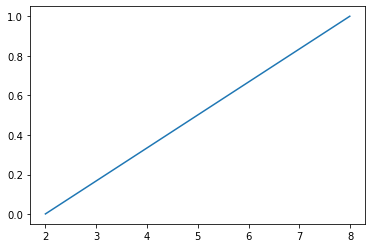

In [5]:
cdf_x = x
cdf_y = np.cumsum(y)/np.sum(y)
plt.plot(cdf_x,cdf_y)
plt.show()

In [6]:
z_pdf = h5py.File('../../HELP/dmu_products/dmu24/dmu24_ELAIS-N1/data/pz_hb_en1.hdf', 'r')

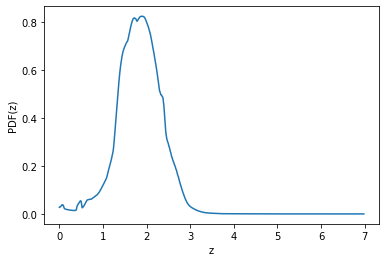

In [7]:
plt.plot(z_pdf['zgrid'],z_pdf['pz'][-7325])
plt.xlabel('z')
plt.ylabel('PDF(z)')
plt.show()

In [8]:
cdf_y = np.cumsum(z_pdf['pz'][-7345])/np.sum(z_pdf['pz'][-7345])
cdf_x = z_pdf['zgrid'].value

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [9]:
source.prior_def['z'] = {'type': 'custom_pdf', 'cdf_x': cdf_y, 'cdf_y':cdf_x} # <---- to fix redshift
#source.prior_def['z'] = {'type': 'uniform', 'limits': [2, 8]} 
source.prior_def['log10LIR'] = {'type': 'uniform', 'limits': [6.,15.]}   
source.prior_def['T'] = {'type': 'uniform', 'limits': [20.,60.]} 
source.prior_def['emissivity'] = {'type': 'uniform', 'limits': [1.,2.]} 

In [10]:
t1 = time.time()
output = source.fit()
t2 = time.time()
print('time taken is: {}'.format(t2-t1))

time taken is: 67.16039252281189


T [21.77067078 25.41628989 37.49106325 46.97959003 50.9907561 ]
emissivity [1.02339067 1.07446495 1.22117198 1.45863692 1.63363445]
z [2.21993685 2.83533011 4.79224725 6.29338442 6.78140514]
log10LIR [12.55600463 12.81446136 13.35792127 13.63287859 13.70550976]


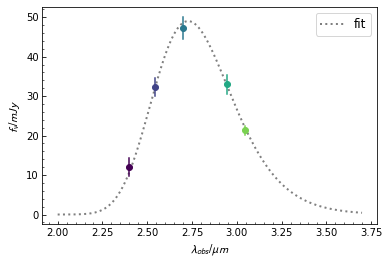

T
emissivity
z
log10LIR


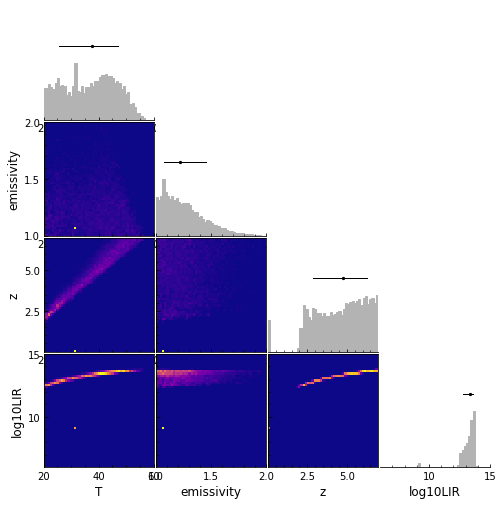

In [21]:
a = analyse.analyser(output)

P = a.P() # returns 5th, 16th, 50th, 84th, 95th percentile 
for p in P.keys(): print(p, P[p])

a.sed_plot()
a.triangle_plot()




In [24]:
inputs = h5py.File('../../greybody_input_EN1.h5','r')

In [29]:
inputs['help_id']

<HDF5 dataset "help_id": shape (218490,), type "|S27">

## Create the HDF5 file that is the input for the full HELP run

In [30]:
#read in the redshift PDFs to find out which sources have redshifts
z_pdf = h5py.File('../../HELP/dmu_products/dmu24/dmu24_ELAIS-N1/data/pz_hb_en1.hdf', 'r')
ids = np.array([name.decode('UTF-8') for name in z_pdf['help_id'].value])

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
#create a two column table with only the help_id and the row number it had in the redshift hdf5 file
c_id = Column(name='help_id',data=ids)
c_num = Column(name='num',data=np.arange(0,len(ids),1))
t1 = Table()
t1.add_columns([c_id,c_num])

In [3]:
#read in the help masterlist
masterlist = Table.read('../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')

In [7]:
masterlist[0]

help_id,field,ra,dec,hp_idx,ebv,redshift,zspec,f_wfc_u,ferr_wfc_u,f_ap_wfc_u,ferr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,flag_wfc_u,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_suprime_g,ferr_suprime_g,f_ap_suprime_g,ferr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_g,merr_ap_suprime_g,flag_suprime_g,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_wfc_g,ferr_wfc_g,f_ap_wfc_g,ferr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,flag_wfc_g,f_suprime_r,ferr_suprime_r,f_ap_suprime_r,ferr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_r,merr_ap_suprime_r,flag_suprime_r,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_wfc_r,ferr_wfc_r,f_ap_wfc_r,ferr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,flag_wfc_r,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_suprime_i,ferr_suprime_i,f_ap_suprime_i,ferr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_i,merr_ap_suprime_i,flag_suprime_i,f_wfc_i,ferr_wfc_i,f_ap_wfc_i,ferr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,flag_wfc_i,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_wfc_z,ferr_wfc_z,f_ap_wfc_z,ferr_ap_wfc_z,m_wfc_z,merr_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,flag_wfc_z,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_suprime_z,ferr_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_z,merr_ap_suprime_z,flag_suprime_z,f_suprime_n921,ferr_suprime_n921,f_ap_suprime_n921,ferr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n921,merr_ap_suprime_n921,flag_suprime_n921,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_suprime_y,ferr_suprime_y,f_ap_suprime_y,ferr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_y,merr_ap_suprime_y,flag_suprime_y,f_ukidss_j,ferr_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,flag_ukidss_j,f_ukidss_k,ferr_ukidss_k,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,flag_ukidss_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag
,,deg,deg,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [33]:
#join the new table with the mastrelist
joined = join(t1,masterlist,join_type='inner',keys='help_id')

In [34]:
#only select sources which have a trusted flux in two or more bands
mask_100 = (~np.isnan(joined['f_pacs_green']) & (joined['flag_pacs_green'])).astype(int)
mask_160 = (~np.isnan(joined['f_pacs_red']) & (joined['flag_pacs_red'])).astype(int)
mask_250 = (~np.isnan(joined['f_spire_250']) & (joined['flag_spire_250'])).astype(int)
mask_350 = (~np.isnan(joined['f_spire_350']) & (joined['flag_spire_350'])).astype(int)
mask_500 = (~np.isnan(joined['f_spire_500']) & (joined['flag_spire_500'])).astype(int)
mask = (mask_100 + mask_160 + mask_250 + mask_250 + mask_350 + mask_500)>1
needed = joined['help_id','num','f_pacs_green','ferr_pacs_green','f_pacs_red','ferr_pacs_red','f_spire_250','ferr_spire_250','f_spire_350','ferr_spire_350','f_spire_500','ferr_spire_500'][mask]

In [35]:
needed

help_id,num,f_pacs_green,ferr_pacs_green,f_pacs_red,ferr_pacs_red,f_spire_250,ferr_spire_250,f_spire_350,ferr_spire_350,f_spire_500,ferr_spire_500
,,mJy,,mJy,,,,,,,
str1728,int64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
HELP_J155620.810+545113.308,2482323,nan,nan,nan,nan,20906.186999999998,3980.425000000003,26584.743,4480.207000000002,28536.203,5316.896000000001
HELP_J155622.752+545007.875,2629662,nan,nan,nan,nan,2092.5143,2675.7252,2062.2246,2575.2471,7125.304,4911.686
HELP_J155628.426+544936.570,2574853,nan,nan,nan,nan,57610.979999999996,3814.3070000000007,51566.753,4147.212999999996,35905.814999999995,4875.199999999993
HELP_J155628.601+545524.359,2699486,nan,nan,nan,nan,21767.074999999997,3945.0099999999984,28908.111999999997,4224.557999999997,29014.214,4922.216
HELP_J155631.071+545619.623,2469759,nan,nan,nan,nan,1423.2975999999999,1905.3827,975.4652,1316.3593999999998,3797.5717000000004,3478.171799999999
HELP_J155633.127+545753.634,2693692,nan,nan,nan,nan,5972.5614,4145.5055999999995,1523.9955,2294.7405,3110.4877,3816.1828999999993
HELP_J155633.669+544934.581,2577169,nan,nan,nan,nan,6786.080400000001,3455.5105999999996,2970.7122,2679.929800000001,2199.3911000000003,2840.5903000000003
HELP_J155633.728+545043.498,2630850,nan,nan,nan,nan,2945.7743,3704.1513999999997,2509.47,3254.6563,2519.6002000000003,3086.3507999999997


In [36]:
#Table.write(needed,'../data/greybody_input_EN1.fits',format='fits')

from astropy.io import registry
from astropy.table.info import serialize_method_as

with serialize_method_as(needed, None):
            registry.write(needed, '../data/greybody_input_EN1.fits',format='fits')

<class 'astropy.table.table.Table'>
fits


In [ ]:
#create the input hdf5 file
hf = h5py.File('../../greybody_input_EN1.h5', 'w') 

In [ ]:
#add the datasets to the file
dt = h5py.string_dtype()
tmp = np.array(needed['help_id'],dtype='S27')
hf.create_dataset('help_id',data=tmp)
tmp = np.array(needed['num'],dtype=int)
hf.create_dataset('num',data=tmp)

hf.create_dataset('f_pacs_green',data=needed['f_pacs_green'])
hf.create_dataset('f_pacs_red',data=needed['f_pacs_red'])
hf.create_dataset('f_spire_250',data=needed['f_spire_250'])
hf.create_dataset('f_spire_350',data=needed['f_spire_350'])
hf.create_dataset('f_spire_500',data=needed['f_spire_500'])

hf.create_dataset('ferr_pacs_green',data=needed['ferr_pacs_green'])
hf.create_dataset('ferr_pacs_red',data=needed['ferr_pacs_red'])
hf.create_dataset('ferr_spire_250',data=needed['ferr_spire_250'])
hf.create_dataset('ferr_spire_350',data=needed['ferr_spire_350'])
hf.create_dataset('ferr_spire_500',data=needed['ferr_spire_500'])

hf.close()

In [5]:
#Create a input file that uses a delta function for the redshifts instead of the full z PDF

#only select sources which have a trusted flux in two or more bands
mask_100 = (~np.isnan(masterlist['f_pacs_green']) & (masterlist['flag_pacs_green'])).astype(int)
mask_160 = (~np.isnan(masterlist['f_pacs_red']) & (masterlist['flag_pacs_red'])).astype(int)
mask_250 = (~np.isnan(masterlist['f_spire_250']) & (masterlist['flag_spire_250'])).astype(int)
mask_350 = (~np.isnan(masterlist['f_spire_350']) & (masterlist['flag_spire_350'])).astype(int)
mask_500 = (~np.isnan(masterlist['f_spire_500']) & (masterlist['flag_spire_500'])).astype(int)
mask = (mask_100 + mask_160 + mask_250 + mask_350 + mask_500)>2
needed = masterlist['help_id','f_pacs_green','ferr_pacs_green','f_pacs_red','ferr_pacs_red','f_spire_250','ferr_spire_250','f_spire_350','ferr_spire_350','f_spire_500','ferr_spire_500','redshift'][mask]

from astropy.io import registry
from astropy.table.info import serialize_method_as

with serialize_method_as(needed, None):
            registry.write(needed, '../data/greybody_input_EN1_z_delta.fits',format='fits')

<class 'astropy.table.table.Table'>
fits


In [6]:
hf = h5py.File('../../greybody_input_EN1_z_delta.h5', 'w') 

#add the datasets to the file
dt = h5py.string_dtype()
tmp = np.array(needed['help_id'],dtype='S27')
hf.create_dataset('help_id',data=tmp)

hf.create_dataset('f_pacs_green',data=needed['f_pacs_green'])
hf.create_dataset('f_pacs_red',data=needed['f_pacs_red'])
hf.create_dataset('f_spire_250',data=needed['f_spire_250'])
hf.create_dataset('f_spire_350',data=needed['f_spire_350'])
hf.create_dataset('f_spire_500',data=needed['f_spire_500'])

hf.create_dataset('ferr_pacs_green',data=needed['ferr_pacs_green'])
hf.create_dataset('ferr_pacs_red',data=needed['ferr_pacs_red'])
hf.create_dataset('ferr_spire_250',data=needed['ferr_spire_250'])
hf.create_dataset('ferr_spire_350',data=needed['ferr_spire_350'])
hf.create_dataset('ferr_spire_500',data=needed['ferr_spire_500'])

hf.create_dataset('redshift',data=needed['redshift'])

hf.close()